# Shopping Cart Abandonment Prediction
## LSTM

LSTM model based on "Predicting purchasing intent: Automatic Feature Learning using
Recurrent Neural Networks" (Sheil, et.al.).

In [ ]:
!wget https://github.com/mease/csci5502-cart-abandonment/raw/main/data/cart_abandon_data_seq_30.zip
!mkdir data
!unzip cart_abandon_data_seq_30.zip -d data

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dense

import numpy as np

In [2]:
# Click sequence for all data points
sequence_length = 30

Load data:

In [3]:
with open('data/X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('data/y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('data/X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('data/y_test.npy', 'rb') as f:
    y_test = np.load(f)

Determine vocabulary size for feature embeddings.

In [4]:
time_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,0]),np.unique(X_test[:,:,0])))))
item_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,1]),np.unique(X_test[:,:,1])))))
cat_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,2]),np.unique(X_test[:,:,2])))))
print(f"Time vocab: {time_vocab_size}, Item vocab: {item_vocab_size}, Category vocab: {cat_vocab_size}")

Time vocab: 4369, Item vocab: 51758, Category vocab: 335


Define the model:

In [5]:
# Timestamp input and embedding
time_inp = Input(shape=(sequence_length,), name='time_input')
time_emb = Embedding(output_dim=10,
                     input_dim=time_vocab_size,
                     input_length=sequence_length,
                     embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                     mask_zero=True,
                     name='time_embedding')(time_inp)

# Item ID input and embedding
item_inp = Input(shape=(sequence_length,), name='item_input')
item_emb = Embedding(output_dim=100,
                     input_dim=item_vocab_size,
                     input_length=sequence_length,
                     embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                     mask_zero=True,
                     name='item_embedding')(item_inp)

# Category input and embedding
cat_inp = Input(shape=(sequence_length,), name='category_input')
cat_emb = Embedding(output_dim=10,
                    input_dim=cat_vocab_size,
                    input_length=sequence_length,
                    embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                    mask_zero=True,
                    name='category_embedding')(cat_inp)

# Concatenate embeddings
concat_emb = Concatenate(axis=2, name='concat_embeddings')([time_emb, item_emb, cat_emb])

# LSTM
lstm1 = LSTM(256, return_sequences=True, name='lstm1')(concat_emb)
lstm2 = LSTM(256, return_sequences=True, name='lstm2')(lstm1)
lstm3 = LSTM(256, name='lstm3')(lstm2)

# Output layer
out = Dense(1, activation='sigmoid', name='output')(lstm3)

model = Model(inputs=[time_inp, item_inp, cat_inp], outputs=[out])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc')])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 category_input (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 time_embedding (Embedding)     (None, 30, 10)       43690       ['time_input[0][0]']             
                                                                                              

Train model:

In [6]:
model.fit([X_train[:,:,0], X_train[:,:,1], X_train[:,:,2]], y_train,
          validation_data=([X_test[:,:,0], X_test[:,:,1], X_test[:,:,2]], y_test),
          epochs=3,
          batch_size=256)

Epoch 1/3
28836/28836 [==============================] - 1476s 51ms/step - loss: 0.1759 - tp: 6691.0000 - fp: 5840.0000 - tn: 6973403.0000 - fn: 395921.0000 - accuracy: 0.9456 - precision: 0.5340 - recall: 0.0166 - auc: 0.8055 - val_loss: 0.1704 - val_tp: 3318.0000 - val_fp: 2661.0000 - val_tn: 1742150.0000 - val_fn: 97335.0000 - val_accuracy: 0.9458 - val_precision: 0.5549 - val_recall: 0.0330 - val_auc: 0.8258
Epoch 2/3
28836/28836 [==============================] - 1441s 50ms/step - loss: 0.1671 - tp: 19501.0000 - fp: 15489.0000 - tn: 6963754.0000 - fn: 383111.0000 - accuracy: 0.9460 - precision: 0.5573 - recall: 0.0484 - auc: 0.8361 - val_loss: 0.1691 - val_tp: 2602.0000 - val_fp: 1891.0000 - val_tn: 1742920.0000 - val_fn: 98051.0000 - val_accuracy: 0.9458 - val_precision: 0.5791 - val_recall: 0.0259 - val_auc: 0.8300
Epoch 3/3
28836/28836 [==============================] - 1443s 50ms/step - loss: 0.1634 - tp: 28317.0000 - fp: 20862.0000 - tn: 6958381.0000 - fn: 374295.0000 - accur

In [7]:
prediction = model.predict([X_test[:,:,0], X_test[:,:,1], X_test[:,:,2]])
y_pred = (prediction > 0.5)

In [8]:
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9484    0.9967    0.9719   1744811
           1     0.5089    0.0590    0.1058    100653

    accuracy                         0.9456   1845464
   macro avg     0.7286    0.5279    0.5389   1845464
weighted avg     0.9244    0.9456    0.9247   1845464



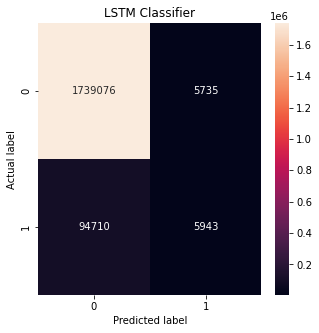

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("LSTM Classifier")
plt.show()